# Task space inverse dynamics control
### Point-to-point

In [1]:
import numpy as np
from simulator import Simulator
from pathlib import Path
from typing import Dict
import os 
import pinocchio as pin
import matplotlib.pyplot as plt
from IPython.display import Video, Image

In [2]:
current_dir = os.getcwd()
xml_path = os.path.join(current_dir, "robots/universal_robots_ur5e/ur5e.xml")
model = pin.buildModelFromMJCF(xml_path)
data = model.createData()

Для того, чтобы сделать TSID контроллер, неохбодимо сделать 2 контура обратных связей. Первый переводит $\mathbf{X^d} \rightarrow \mathbf{a_q}$ (outer loop), а второй контур - $\mathbf{a_q} \rightarrow \mathbf{u}$ (inner loop)

Первый контур:

\begin{equation}
a_X=\ddot{X}^d - k_p(X - X^d) - k_d(\dot{X}-\dot{X}^d)
\end{equation}

\begin{equation}
a_q = J^{-1}(a_X - \dot{J}\dot{q})
\end{equation}

Второй контур:

\begin{equation}
u = \mathbf{M(q)}a_q + \mathbf{C(q,\dot{q})}\dot{q} + \mathbf{g(q)}
\end{equation}


При этом $\mathbf{X} \in \mathbb{R}^6$ 3 линейный координаты и 3 угловые, для составления ошибки по вращению (3-х мерный вектор) использована следующая формула:

\begin{equation}
\mathbf{\tilde{S}} = -log(\mathbf{R^d R^T})
\end{equation}

Для ошибки по положению:

\begin{equation}
\mathbf{\tilde{p}} = \mathbf{p} - \mathbf{p^d}
\end{equation}

In [9]:
def task_space_p2p_controller(q: np.ndarray, dq: np.ndarray, t: float, desired: Dict) -> np.ndarray:
    
    #PD coeff
    kp = np.array([200, 200, 200, 200, 200, 200])*np.eye(6) 
    kd = np.array([100, 100, 100, 100, 100, 100])*np.eye(6)

    # Convert desired pose to SE3
    desired_position = desired['pos']
    desired_quaternion = desired['quat'] # [w, x, y, z] in MuJoCo format
    desired_quaternion_pin = np.array([*desired_quaternion[1:], desired_quaternion[0]]) # Convert to [x,y,z,w] for Pinocchio
    # Convert to pose and SE3
    desired_pose = np.concatenate([desired_position, desired_quaternion_pin])
    desired_se3 = pin.XYZQUATToSE3(desired_pose)

    #desired parameters
    R_des = desired_se3.rotation
    p_des = desired_se3.translation
    ddX_des = np.zeros(6)
    dX_des = np.zeros(6)

    pin.computeAllTerms(model, data, q, dq)
    pin.forwardKinematics(model, data, q, dq)

    # Get the frame pose
    ee_frame_id = model.getFrameId("end_effector")
    #pin.updateFramePlacement(model, data, ee_frame_id)
    ee_pose = data.oMf[ee_frame_id]
    ee_position = ee_pose.translation
    ee_rotation = ee_pose.rotation

    # Get velocities and accelerations
    frame = pin.WORLD
    twist = pin.getFrameVelocity(model, data, ee_frame_id, frame).vector
    dtwist = pin.getFrameAcceleration(model, data, ee_frame_id, frame)
    J = pin.getFrameJacobian(model, data, ee_frame_id, frame)
    dJ = pin.computeJointJacobiansTimeVariation(model, data, q, dq)

    #state error
    error_rot = -pin.log3(R_des @ ee_rotation.T)
    X_error = np.hstack([ee_position - p_des, error_rot])

    #outer loop and inner loop
    a_x = ddX_des - kp @ X_error - kd @ (twist - dX_des)
    a_q = np.linalg.inv(J)@(a_x - dJ@dq)
    tau = data.M @ a_q + data.nle

    print(f'p_desired : {p_des}')
    print(f'R_desired : {R_des}')
    print(f'p_end_effecor : {ee_position}')
    print(f'R_end_effecor : {ee_rotation}')
    print(f'X_error : {X_error}')

    return tau

In [10]:
# Create logging directories
Path("logs/videos").mkdir(parents=True, exist_ok=True)

print("\nRunning task space controller...")
sim = Simulator(
    xml_path="robots/universal_robots_ur5e/scene.xml",
    enable_task_space=True,
    show_viewer=True,
    record_video=True,
    video_path="logs/videos/05_hw_task_space.mp4",
    fps=30,
    width=1920,
    height=1080
)

sim.set_controller(task_space_p2p_controller)
sim.run(time_limit=10.0)

times = np.array(sim.times)
positions = np.array(sim.positions)
velocities = np.array(sim.velocities)


Running task space controller...
p_desired : [0.5 0.  0.5]
R_desired : [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
p_end_effecor : [0.49199873 0.13399971 0.50800037]
R_end_effecor : [[-1.34924357e-11  3.67320510e-06  1.00000000e+00]
 [-1.00000000e+00 -3.67320510e-06  0.00000000e+00]
 [ 3.67320510e-06 -1.00000000e+00  3.67320510e-06]]
X_error : [-0.00800127  0.13399971  0.00800037 -1.20919958  1.20919513 -1.20920402]
p_desired : [0.5 0.  0.5]
R_desired : [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
p_end_effecor : [0.49229368 0.13444121 0.50854265]
R_end_effecor : [[ 9.77019597e-04  3.68735831e-03  9.99992724e-01]
 [-9.99996102e-01  2.61928462e-03  9.67364586e-04]
 [-2.61569854e-03 -9.99989771e-01  3.68990303e-03]]
X_error : [-0.00770632  0.13444121  0.00854265 -1.20501634  1.20700426 -1.20829846]
p_desired : [0.5 0.  0.5]
R_desired : [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
p_end_effecor : [0.49275941 0.13523644 0.50955836]
R_end_effecor : [[ 0.00275961  0.00955412  0.99995055]
 [-0.99996939  0.00734738

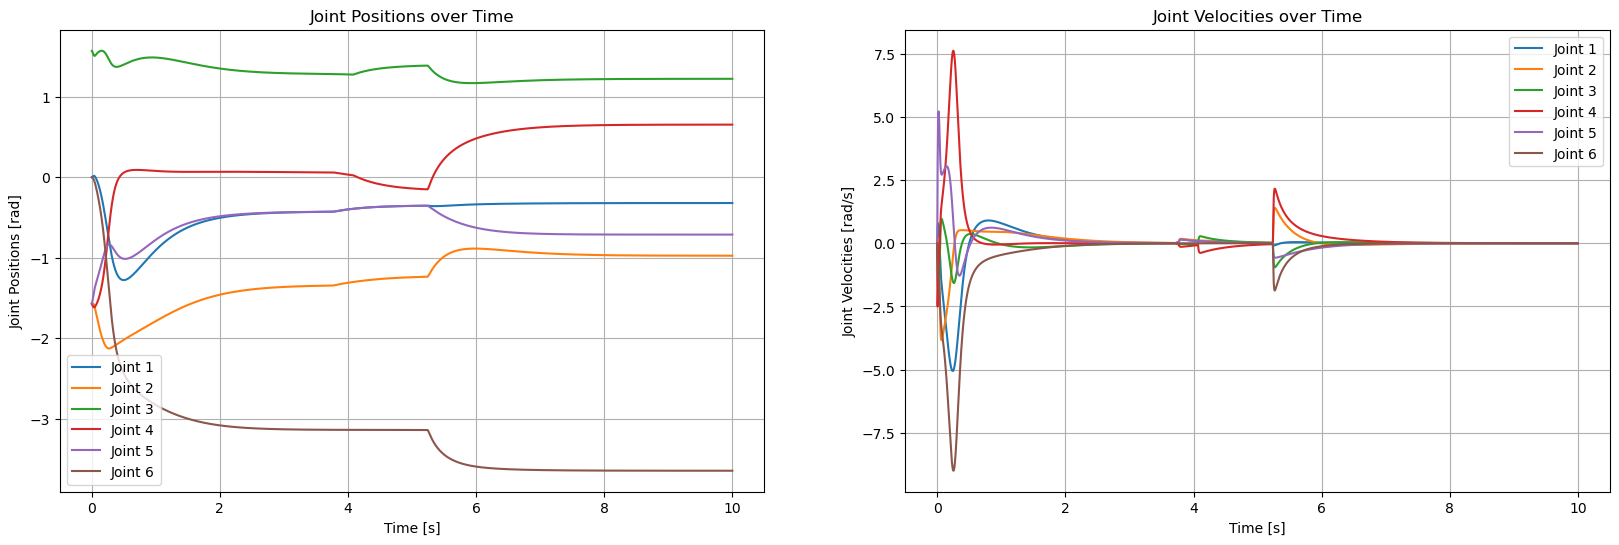

In [12]:
# Process and save results
plt.figure(figsize=(20, 6))

# Joint positions plot
plt.subplot(121)
for i in range(positions.shape[1]):
    plt.plot(times, positions[:, i], label=f'Joint {i+1}')
plt.xlabel('Time [s]')
plt.ylabel('Joint Positions [rad]')
plt.title('Joint Positions over Time')
plt.legend()
plt.grid(True)
plt.savefig('logs/plots/05_hw_task_space_positions.png')

# Joint velocities plot
plt.subplot(122)
for i in range(velocities.shape[1]):
    plt.plot(times, velocities[:, i], label=f'Joint {i+1}')
plt.xlabel('Time [s]')
plt.ylabel('Joint Velocities [rad/s]')
plt.title('Joint Velocities over Time')
plt.legend()
plt.grid(True)
plt.savefig('logs/plots/05_hw_task_space_velocities.png')

plt.show()

In [ ]:
Video(os.path.join(current_dir, "logs/videos/05_hw_task_space.mp4"))

В качестве траектории выберем окружность, зададим ее параметрически:

\begin{equation}
\begin{cases}
x = x_{center} + rad \cdot sin(\omega t)\\
y = y_{center} + rad \cdot cos(\omega t)\\
z = constant
\end{cases}
\end{equation}

При этом пусть центром круга куб, а его ориентация определит ориентацию рабочего органа

In [3]:
def get_trajectory(p_des, t):
    """Calculating trajectory points"""
    
    X_des = np.zeros(6)
    dX_des = np.zeros(6)
    ddX_des = np.zeros(6)

    x = p_des[0] + 0.2*np.sin(1*t)
    y = p_des[1] + 0.2*np.cos(1*t)
    z = p_des[2]

    dx = 0.2*np.cos(1*t)
    dy = -0.2*np.sin(1*t)
    dz = 0

    ddx = -0.2*np.sin(1*t)
    ddy = -0.2*np.cos(1*t)
    ddz = 0
    
    X_des[:3] = np.hstack([x,y,z])
    dX_des[:3] = np.hstack([dx,dy,dz])
    ddX_des[:3] = np.hstack([ddx,ddy,ddz])
    
    return X_des, dX_des, ddX_des

In [4]:
def task_space_traj_controller(q: np.ndarray, dq: np.ndarray, t: float, desired: Dict) -> np.ndarray:
    
    #PD coeff
    kp = np.array([200, 200, 200, 200, 200, 200])*np.eye(6)
    kd = np.array([100, 100, 100, 100, 100, 100])*np.eye(6)

    # Convert desired pose to SE3
    desired_position = desired['pos']
    desired_quaternion = desired['quat'] # [w, x, y, z] in MuJoCo format
    desired_quaternion_pin = np.array([*desired_quaternion[1:], desired_quaternion[0]]) # Convert to [x,y,z,w] for Pinocchio
    # Convert to pose and SE3
    desired_pose = np.concatenate([desired_position, desired_quaternion_pin])
    desired_se3 = pin.XYZQUATToSE3(desired_pose)
    R_des = desired_se3.rotation
    p_des = desired_se3.translation
    
    #Getting next point
    X_des, dX_des, ddX_des = get_trajectory(p_des, t)

    pin.computeAllTerms(model, data, q, dq)
    pin.forwardKinematics(model, data, q, dq)

    # Get the frame pose
    ee_frame_id = model.getFrameId("end_effector")
    #pin.updateFramePlacement(model, data, ee_frame_id)
    ee_pose = data.oMf[ee_frame_id]
    ee_position = ee_pose.translation
    ee_rotation = ee_pose.rotation

    # Get velocities and accelerations
    frame = pin.WORLD
    twist = pin.getFrameVelocity(model, data, ee_frame_id, frame).vector
    dtwist = pin.getFrameAcceleration(model, data, ee_frame_id, frame)
    J = pin.getFrameJacobian(model, data, ee_frame_id, frame)
    dJ = pin.computeJointJacobiansTimeVariation(model, data, q, dq)

    #state error
    error_rot = -pin.log3(R_des @ ee_rotation.T)
    X_error = np.zeros(6)
    X_error[:3] = ee_position - X_des[:3]
    X_error[3:] = error_rot

    #outer loop and inner loop
    a_x = ddX_des - kp @ X_error - kd @ (twist - dX_des)
    a_q = np.linalg.inv(J)@(a_x - dJ@dq)
    tau = data.M @ a_q + data.nle

    print(f'X_error : {X_error}')

    return tau

In [5]:
print("\nRunning task space controller...")
sim = Simulator(
    xml_path="robots/universal_robots_ur5e/scene.xml",
    enable_task_space=True,
    show_viewer=True,
    record_video=True,
    video_path="logs/videos/05_hw_task_space_traj.mp4",
    fps=30,
    width=1920,
    height=1080
)

sim.set_controller(task_space_traj_controller)
sim.run(time_limit=20.0)

times = np.array(sim.times)
positions = np.array(sim.positions)
velocities = np.array(sim.velocities)


Running task space controller...
X_error : [-0.00800127 -0.06600029  0.00800037 -1.20919958  1.20919513 -1.20920402]
X_error : [-0.00811584 -0.06546679  0.00853847 -1.2052242   1.20697392 -1.20840422]
X_error : [-0.00806752 -0.06450571  0.00954634 -1.19863304  1.20353069 -1.20659883]
X_error : [-0.00795382 -0.0632026   0.01097069 -1.19050195  1.19965629 -1.20363368]
X_error : [-0.00784392 -0.06163461  0.01275776 -1.18154456  1.19580843 -1.19951029]
X_error : [-0.00777434 -0.05988295  0.01483854 -1.17200014  1.19195689 -1.19450944]
X_error : [-0.0077749  -0.05801335  0.01715659 -1.16206519  1.1880819  -1.18885473]
X_error : [-0.00786994 -0.05607897  0.01966525 -1.15190129  1.18417136 -1.18272448]
X_error : [-0.00807924 -0.05412276  0.02232557 -1.14164141  1.18021869 -1.17626107]
X_error : [-0.00841888 -0.05217952  0.02510474 -1.13139501  1.17622116 -1.1695784 ]
X_error : [-0.00890183 -0.05027751  0.02797496 -1.12125222  1.17217865 -1.1627678 ]
X_error : [-0.00953856 -0.04843976  0.0309

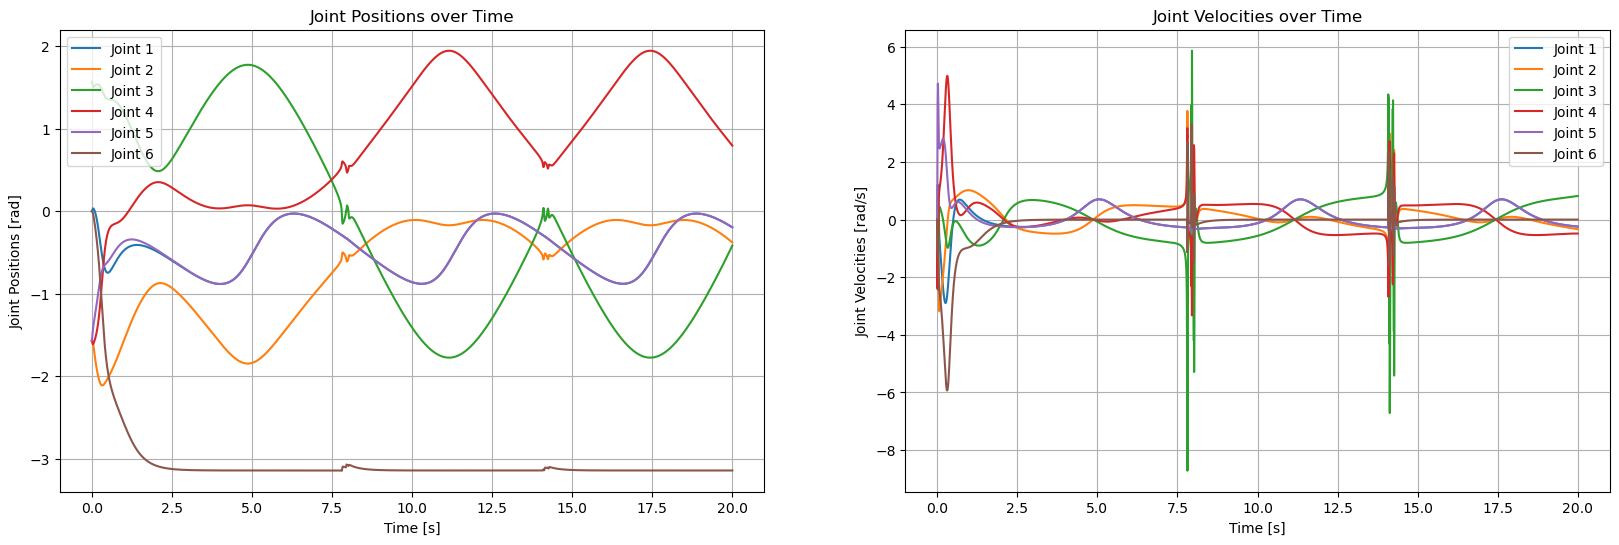

In [6]:
# Process and save results
plt.figure(figsize=(20, 6))

# Joint positions plot
plt.subplot(121)
for i in range(positions.shape[1]):
    plt.plot(times, positions[:, i], label=f'Joint {i+1}')
plt.xlabel('Time [s]')
plt.ylabel('Joint Positions [rad]')
plt.title('Joint Positions over Time')
plt.legend()
plt.grid(True)

# Joint velocities plot
plt.subplot(122)
for i in range(velocities.shape[1]):
    plt.plot(times, velocities[:, i], label=f'Joint {i+1}')
plt.xlabel('Time [s]')
plt.ylabel('Joint Velocities [rad/s]')
plt.title('Joint Velocities over Time')
plt.legend()
plt.grid(True)
plt.savefig('logs/plots/05_hw_task_space_joint_traj.png')

plt.show()

In [ ]:
Video(os.path.join(current_dir, "logs/videos/05_hw_task_space_traj.mp4"))

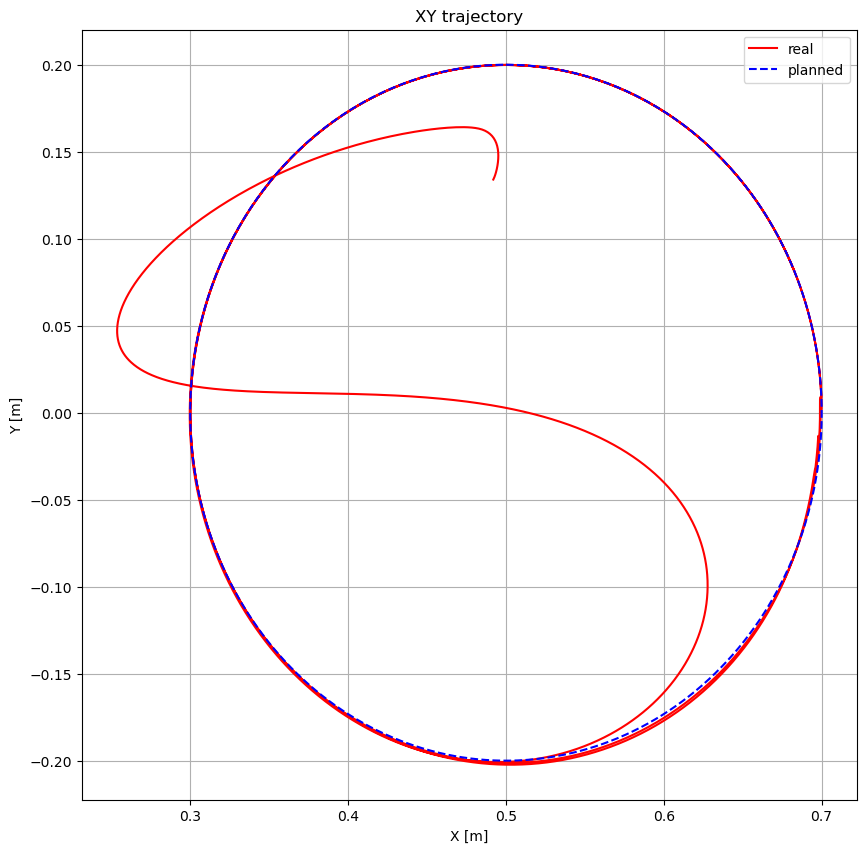

In [8]:
#trajectory on XY plane

x = []
y = []
z = []
x_pl = []
y_pl = []
z_pl = []
ee_frame_id = model.getFrameId("end_effector")
for i in range(len(times)-1):
    pin.forwardKinematics(model, data, positions[i], velocities[i])
    pin.updateFramePlacement(model, data, ee_frame_id)
    ee_pose = data.oMf[ee_frame_id]
    ee_position = ee_pose.translation
    x.append(ee_position[0])
    y.append(ee_position[1])
    z.append(ee_position[2])

    x_pl.append(0.5 + 0.2*np.sin(0.0002*np.pi*i))
    y_pl.append(0 + 0.2*np.cos(0.0002*np.pi*i))


plt.figure(figsize=(10, 10))
plt.plot(x, y, 'r', label = 'real')
plt.plot(x_pl, y_pl,'--b', label = 'planned', )
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('XY trajectory')
plt.legend()
plt.grid(True)
plt.savefig('logs/plots/05_hw_task_space_xy_traj.png')
plt.show()